# <span style='color:red'>Project 4.  Due December 1</span>
Please note: no consultations/questions after November 28

In this project we develop an updated first-order algorithm to construct a portfolio using intraday data; now with position bounds and using projected gradients.

In [5]:
import csv
import sys
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime, time
from functools import reduce
import itertools
import warnings
warnings.filterwarnings('ignore')

We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.

The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.

We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

The assets that we will use are: ABR, AMZN, GS, NFLX, NIO, NVDA, TSLA, UBS.

# data
backfill missing noon values

In [6]:
data_dir = "./dataforh4/"
asset_list = ["ABR", "AMZN", "GS", "NFLX", "NIO", "NVDA", "TSLA", "UBS"]

In [7]:
def is_open_or_noon(dt: datetime.datetime) -> bool:
    t = dt.time()
    return t == datetime.time(9,30) or t == datetime.time(12,0)

def read_asset(data_dir, asset):
    df = pd.read_csv(f"{data_dir}{asset}.csv", low_memory=False, header=3).loc[:, ['Dates', 'Close']]
    # read only valid rows
    df = df.iloc[:df["Close"].isna().argmax()]
    # handle "#NAME" at the beginning
    if df.loc[0,"Dates"]=="#NAME?":
        df.loc[0,"Dates"] = df.loc[1,"Dates"].replace("31", "30")
    # convert to datetime
    df["Dates"] = pd.to_datetime(df["Dates"])
    # get date
    df['date'] = df['Dates'].apply(lambda dt: dt.date())
    
    # extract open and noon data
    open_or_noon = df["Dates"].apply(is_open_or_noon)
    df_on = df.loc[open_or_noon]
    
    # get dates where open or noon is missing
    df2 = df_on.groupby('date').count()['Dates'].reset_index()
    missing_dates_list = list(df2['date'].loc[df2['Dates']==1])
    
    # backfill open or noon missing values
    for date in missing_dates_list:
        df_date = df.loc[df['date']==date]
        # check open
        open_str = datetime.datetime.strftime(date, "%Y-%m-%d")+" 09:30:00"
        open_dt = datetime.datetime.strptime(open_str, "%Y-%m-%d %H:%M:%S")
        if (open_dt == df_date['Dates']).any()==False: # no open
            print(f"{asset} {date} no open")
            next_dt = open_dt+datetime.timedelta(minutes=1)
            while (next_dt == df_date['Dates']).any()==False: # no next_dt
                next_dt = next_dt+datetime.timedelta(minutes=1)
            next_value = float(df_date.loc[df_date['Dates']==next_dt, 'Close'])
            print(f"backfill open with {next_dt}, {next_value}")
            df_on.loc[len(df_on.index)] = [open_dt, next_value, date]
        # check noon
        noon_str = datetime.datetime.strftime(date, "%Y-%m-%d")+" 12:00:00"
        noon_dt = datetime.datetime.strptime(noon_str, "%Y-%m-%d %H:%M:%S")
        if (noon_dt == df_date['Dates']).any()==False: # no noon
            print(f"{asset} {date} no noon")
            next_dt = noon_dt+datetime.timedelta(minutes=1)
            while (next_dt == df_date['Dates']).any()==False: # no next_dt
                next_dt = next_dt+datetime.timedelta(minutes=1)
            next_value = float(df_date.loc[df_date['Dates']==next_dt, 'Close'])
            print(f"backfill noon with {next_dt}, {next_value}")
            df_on.loc[len(df_on.index)] = [noon_dt, next_value, date]
    df_on = df_on.sort_values(by='Dates').reset_index(drop=True)[['Dates', 'Close']]
    df_on.rename(columns={'Close': f"Close_{asset}"}, inplace=True)
    return df_on

In [8]:
def read_all_assets(data_dir, asset_list):
    df_list = [read_asset(data_dir, asset) for asset in asset_list]
    # only select dates which all assets have open and noon
    df = reduce(lambda x,y: x.merge(y, on='Dates', how='inner'), df_list)
    return df

In [9]:
df = read_all_assets(data_dir, asset_list)
print(df.shape)

ABR 2021-02-01 no noon
backfill noon with 2021-02-01 12:01:00, 14.19
ABR 2021-02-03 no noon
backfill noon with 2021-02-03 12:01:00, 14.8689
ABR 2021-02-18 no noon
backfill noon with 2021-02-18 12:01:00, 15.33
ABR 2021-03-02 no noon
backfill noon with 2021-03-02 12:01:00, 16.5
ABR 2021-03-08 no noon
backfill noon with 2021-03-08 12:01:00, 16.05
ABR 2021-03-23 no noon
backfill noon with 2021-03-23 12:01:00, 16.22
ABR 2021-06-04 no noon
backfill noon with 2021-06-04 12:01:00, 18.3989
ABR 2021-06-16 no noon
backfill noon with 2021-06-16 12:01:00, 18.567
AMZN 2021-04-20 no noon
backfill noon with 2021-04-20 12:01:00, 3323.01
AMZN 2021-06-14 no noon
backfill noon with 2021-06-14 12:01:00, 3367.79
UBS 2021-02-02 no noon
backfill noon with 2021-02-02 12:01:00, 14.82
UBS 2021-02-04 no noon
backfill noon with 2021-02-04 12:01:00, 14.945
UBS 2021-02-11 no noon
backfill noon with 2021-02-11 12:01:00, 15.3
UBS 2021-02-18 no noon
backfill noon with 2021-02-18 12:01:00, 15.2865
UBS 2021-02-19 no noon

In [10]:
def compute_ret(df):
    df['date'] = df['Dates'].apply(lambda x: x.date())
    df2 = df.iloc[:, 1:].groupby('date').apply(lambda x: x.pct_change())
    ret = df2.dropna(axis=0).values
    return ret

In [11]:
ret = compute_ret(df)
print(ret.shape)

(111, 8)


In [12]:
ret_train, ret_test = ret[:100, :], ret[100:, :]
print(ret_train.shape, ret_test.shape)

(100, 8) (11, 8)


In [13]:
ret_train.mean(axis=0), ret_test.mean(axis=0)

(array([ 6.60772526e-04, -3.34350359e-04,  5.34521292e-04, -2.97171563e-04,
        -1.32687810e-03, -5.07862235e-05, -2.02622630e-03,  9.65053328e-04]),
 array([-0.00188694,  0.00276406,  0.00146769,  0.0009571 , -0.00426307,
         0.00102725, -0.00068068, -0.0001432 ]))

# eval_func, eval_grad

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0$.

$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)$$

$$ \text{subject to} \ |x_j| \le 1 \ \text{for all names $j$}$$
#### Unlike what we did on project $2$, the risk term is **not** raised to the power $1/\pi$.


In [14]:
def eval_func(theta, pi, ret, x):
    # ret: (T,n)
    # x: (n,) 
    ret_bar = np.mean(ret, axis=0) # ret_bar: (n,)
    f1 = ret_bar.dot(x)
    
    ret_dev = ret - ret_bar # ret_dev: (T,n)
    ret_dev_x = ret_dev.dot(x) # ret_dev_x: (T,)
    f2 = np.mean( ret_dev_x**pi )
    return -f1 + theta*f2

def eval_grad(theta, pi, ret, x):
    # ret: (T,n)
    # x: (n,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (n,)
    ret_dev = ret - ret_bar # ret_dev: (T,n)
    ret_dev_x = ret_dev.dot(x) # ret_dev_x: (T,)

    tmp = np.dot(ret_dev.T, ret_dev_x**(pi-1)) # tmp: (n,)
    T = ret.shape[0]
    return -ret_bar + (theta*pi/T)*tmp

In [15]:
print(eval_func(5, 2, ret_train, np.ones(8)/8), eval_grad(5, 2, ret_train, np.ones(8)/8))
print(eval_func(1000, 4, ret_train, np.ones(8)/8), eval_grad(1000, 4, ret_train, np.ones(8)/8))

0.0007454824389507503 [ 2.09741933e-05  8.63619066e-04 -9.56235050e-05  8.81307680e-04
  4.10533428e-03  1.07157688e-03  3.93636316e-03 -7.30898132e-04]
0.0003235203013081492 [-0.00026661  0.00051765 -0.00027699  0.00041716  0.00220897  0.00035374
  0.00265031 -0.00087678]


In [16]:
import numpy as np
from typing import Tuple
def evalfunc_rl(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> float:
    # compute mean returns first. ret_mu shape should be (3,)
    ret_mu = ret.mean(axis=0)

    # first part
    drift = -ret_mu.dot(portfolio)

    # second part
    # weighed deviation from mean (part within []^pi)
    deviation = (ret - ret_mu).dot(portfolio)
    risk = theta * (
        (np.abs(deviation)**pi).mean()
    )
    return drift + risk

def evalgrad_rl(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> np.ndarray:
    T = ret.shape[0]
    ret_mu = ret.mean(axis=0)
    delta = ret - ret_mu
    dev = delta.dot(portfolio)
    nom = dev * np.absolute(dev)**(pi-2)
    return -ret_mu + (
        (theta * pi/ T)*nom
    ).dot(delta)


In [17]:
print(evalfunc_rl(np.ones(8)/8, ret_train, 2, 5), evalgrad_rl(np.ones(8)/8, ret_train, 2, 5))
print(evalfunc_rl(np.ones(8)/8, ret_train, 4, 1000), evalgrad_rl(np.ones(8)/8, ret_train, 4, 1000))

0.0007454824389507503 [ 2.09741933e-05  8.63619066e-04 -9.56235050e-05  8.81307680e-04
  4.10533428e-03  1.07157688e-03  3.93636316e-03 -7.30898132e-04]
0.0003235203013081492 [-0.00026661  0.00051765 -0.00027699  0.00041716  0.00220897  0.00035374
  0.00265031 -0.00087678]


# first-order method

<span style='color:red'> Develop a first-order method to address this computational problem.</span>

Your method should work with values of $T$ at least $100$.

Make sure your code works with $\pi = 2$ and $\pi = 4$.  For $\pi = 2$ use $\theta = 5$. You should be able to get meaningful problem behavior (i.e., nonzero portfolio).  And when $\pi = 4$ use $\theta = 1000$.

Suggestion: first apply the problem to one asset at a time, i.e., $n = 1$.  Then use $n = 2$.  And only then try the entire set of names.  And use $\pi = 2$ before trying $\pi = 4$.

## backtrack, momentum

In [18]:
def backtrack(theta, pi, ret, x, fval, grad, delta, alpha, beta, t_init, t_eps): 
    # alpha = 0.5, beta = 0.75, t_init = 1, t_eps = 1e-4
    gradtimesdelta = grad.dot(delta)
    t = t_init
    goon = True
    success = False
    while goon:
        xnew = x+t*delta
        fnew = eval_func(theta, pi, ret, xnew)
        target = alpha*t*gradtimesdelta 
        if fnew - fval <= target: # target means the difference that is acceptable between fnew and fval
            goon = False
            success = True # accept if small enough
        else:
            t *= beta
        if t < t_eps: 
            if fnew <= fval: success = True
            goon = False
    return t, success

def run_backtrack(theta, pi, ret, x, alpha, beta, t_init, t_eps, max_iter):
    converged = False
    x_history = np.zeros((max_iter, len(x)))
    f_history = np.zeros(max_iter)
    
    iter = 0
    while iter < max_iter:
        x_history[iter] = x
        fval = eval_func(theta, pi, ret, x)
        f_history[iter] = fval
        
        grad = eval_grad(theta, pi, ret, x)
        
        delta = -grad
        
        for j in range(len(x)):
            if x[j] < -1: delta[j] = max(0.0, delta[j]) # this is the critical correction, doing projection here
            if x[j] > 1: delta[j] = min(0.0, delta[j])

        t, goodstep = backtrack(theta, pi, ret, x, fval, grad, delta, alpha, beta, t_init, t_eps)

        '''
        if iter%5000==0:
            print(f"iter={iter}, t={t}, goodstep={goodstep}, grad={np.round(grad,6)}, grad l2norm={np.linalg.norm(grad)}")
        '''
        
        if goodstep:
            newx = np.zeros(len(x))
            for j in range(len(x)):
                newx[j] = max(-1.0, x[j]+t*delta[j])
                newx[j] = min(1.0, newx[j]) # this is the critical correction, doing projection here
            newfval = eval_func(theta, pi, ret, newx)
            
            grad_zero = np.isclose(grad, 0)
            abs_one = np.isclose(np.abs(newx), 1)
            if np.logical_or(grad_zero, abs_one).all():
                converged = True
                print(f"Converged at {iter}")
                break
            
            x = newx
        
        iter +=1
    return iter, converged, x_history, f_history, newx, newfval

def run_momentum(theta, pi, ret, x, alpha, beta, t_init, t_eps, mu, max_iter):
    converged = False
    x_history = np.zeros((max_iter, len(x)))
    f_history = np.zeros(max_iter)
    olddelta = np.zeros(len(x))
    
    iter = 0
    while iter < max_iter:
        x_history[iter] = x
        fval = eval_func(theta, pi, ret, x)
        f_history[iter] = fval
        
        grad = eval_grad(theta, pi, ret, x)
        
        delta = -grad + (1-mu)*olddelta # delta defined as moving average of current and historical gradient
        for j in range(len(x)):
            if x[j] < -1: delta[j] = max(0.0, delta[j]) # this is the critical correction, doing projection here
            if x[j] > 1: delta[j] = min(0.0, delta[j])

        t, goodstep = backtrack(theta, pi, ret, x, fval, grad, delta, alpha, beta, t_init, t_eps)

        '''
        if iter%5000==0:
            print(f"iter={iter}, t={t}, goodstep={goodstep}, grad={np.round(grad, 6)}, grad l2norm={np.linalg.norm(grad)}")
        '''

        if goodstep:
            newx = np.zeros(len(x))
            for j in range(len(x)):
                newx[j] = max(-1.0, x[j]+t*delta[j]) # this is the critical correction, doing projection here
                newx[j] = min(1.0, newx[j]) 
            olddelta = delta
            newfval = eval_func(theta, pi, ret, newx)
            
            grad_zero = np.isclose(grad, 0)
            abs_one = np.isclose(np.abs(newx), 1)
            if np.logical_or(grad_zero, abs_one).all():
                converged = True
                print(f"Converged at {iter}")
                break
            
            x = newx
            
        iter +=1
    return iter, converged, x_history, f_history, newx, newfval

## small demo example

### helper function to plot x_history and f_history

In [45]:
def plot_result(iter, x_history, f_history):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=[20,6], sharex=True)
    ax1.plot(f_history[:iter+1])
    for j in range(x_history.shape[1]):
        ax2.plot(x_history[:iter+1, j], label="x_"+str(j))
    ax2.legend()
    plt.show()

### theta=5, pi=2, T=100

Converged at 16068
start at=[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125], converged True at iter 16068, final x=[ 0.3041  0.0136  0.0086 -0.1057  0.0302  0.3531 -0.589   1.    ], final f=-0.001388


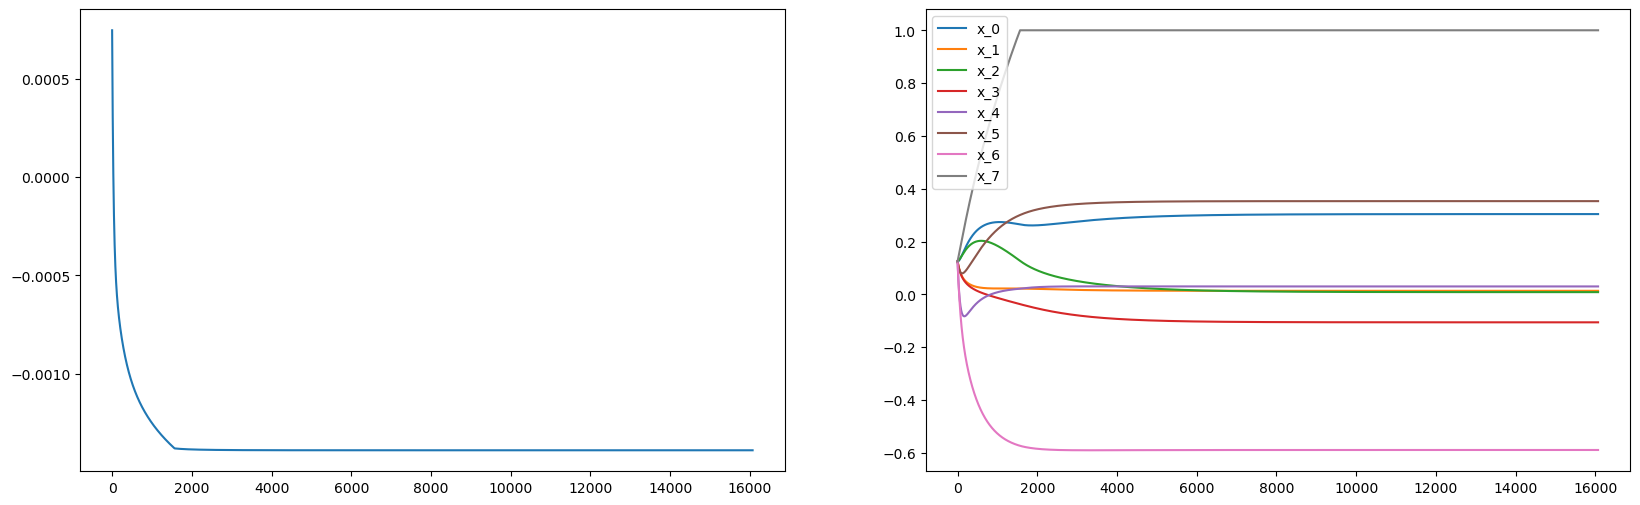

In [16]:
theta=5; pi=2; initx = np.ones(8)/8
alpha = 0.5; beta=0.75; t_init=1; t_eps=1e-20; max_iter=50000

iter, converged, x_history, f_history, newx, newfval = run_backtrack(theta, pi, ret_train, initx, alpha, beta, t_init, t_eps, max_iter)
    
print(f"start at={initx}, converged {converged} at iter {iter}, final x={np.round(newx, 4)}, final f={np.round(newfval, 6)}")
if not converged: 
    finalgrad = eval_grad(theta, pi, ret_train,newx)
    print(f"final grad={finalgrad}, final grad l2 norm={np.linalg.norm(finalgrad)}")

plot_result(iter, x_history, f_history)

Converged at 14460
start at=[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125], converged True at iter 14460, final x=[ 0.3041  0.0136  0.0086 -0.1057  0.0302  0.3531 -0.589   1.    ], final f=-0.001388


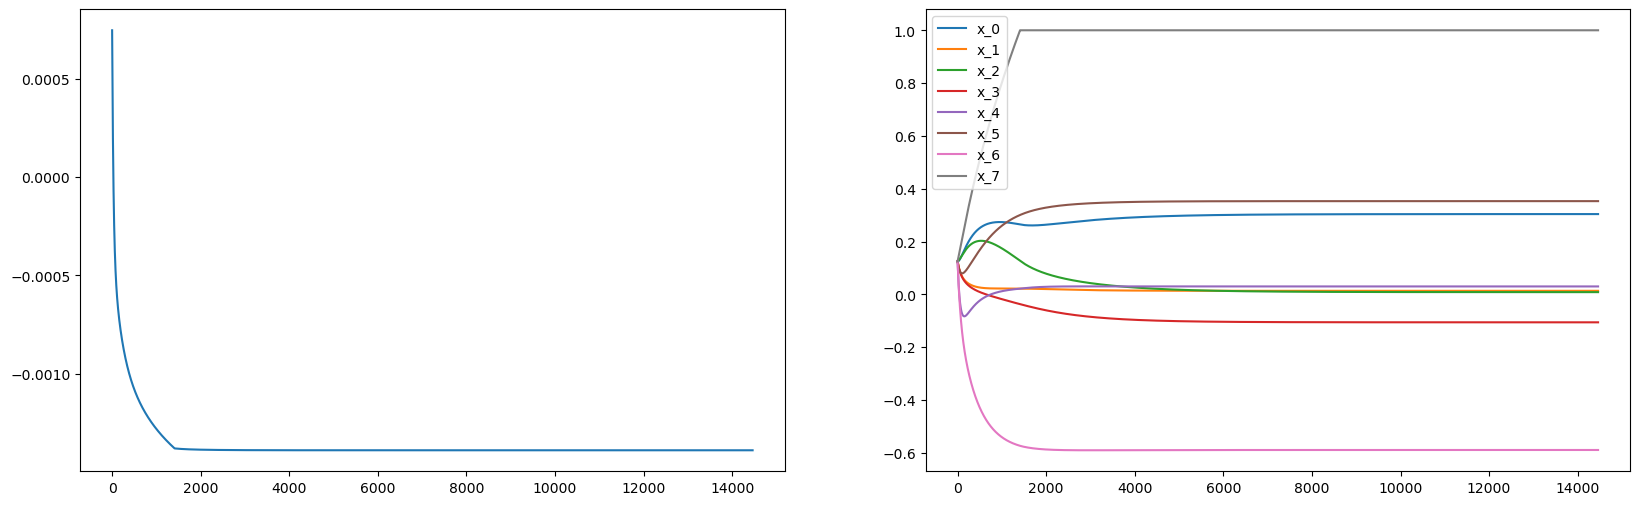

In [17]:
theta=5; pi=2; initx = np.ones(8)/8
alpha = 0.5; beta=0.75; t_init=1; t_eps=1e-20; mu = 0.9; max_iter=50000

iter, converged, x_history, f_history, newx, newfval = run_momentum(theta, pi, ret_train, initx, alpha, beta, t_init, t_eps, mu, max_iter)
    
print(f"start at={initx}, converged {converged} at iter {iter}, final x={np.round(newx, 4)}, final f={np.round(newfval, 6)}")
if not converged: 
    finalgrad = eval_grad(theta, pi, ret_train,newx)
    print(f"final grad={finalgrad}, final grad l2 norm={np.linalg.norm(finalgrad)}")

plot_result(iter, x_history, f_history)

### theta=1000, pi=4, T=100

Converged at 35055
start at=[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125], converged True at iter 35055, final x=[ 0.537727  0.072156  0.332587 -0.222846  0.163164  0.542946 -1.
  1.      ], final f=-0.002678


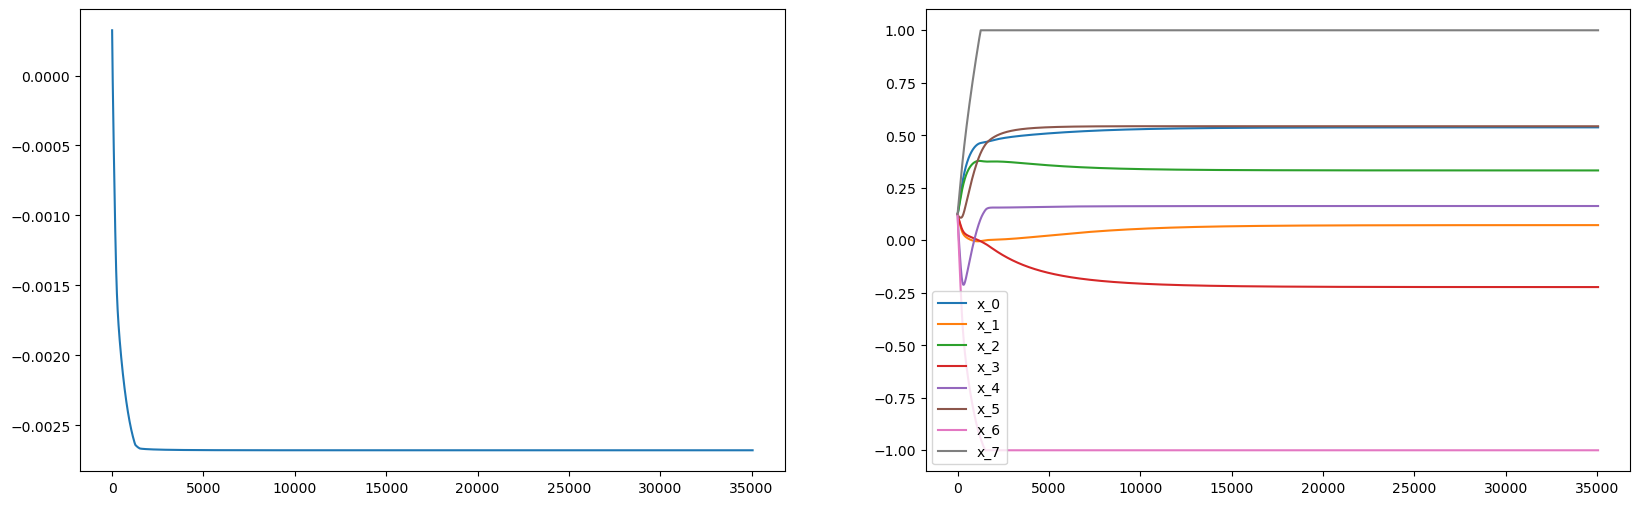

In [18]:
theta=1000; pi=4; initx = np.ones(8)/8
alpha = 0.5; beta=0.75; t_init=1; t_eps=1e-8; max_iter=50000

iter, converged, x_history, f_history, newx, newfval = run_backtrack(theta, pi, ret_train, initx, alpha, beta, t_init, t_eps, max_iter)
    
print(f"start at={initx}, converged {converged} at iter {iter}, final x={np.round(newx, 6)}, final f={np.round(newfval, 6)}")
if not converged: 
    finalgrad = eval_grad(theta, pi, ret_train,newx)
    print(f"final grad={finalgrad}, final grad l2 norm={np.linalg.norm(finalgrad)}")

plot_result(iter, x_history, f_history)

Converged at 31549
start at=[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125], converged True at iter 31549, final x=[ 0.537727  0.072156  0.332587 -0.222846  0.163164  0.542946 -1.
  1.      ], final f=-0.002678


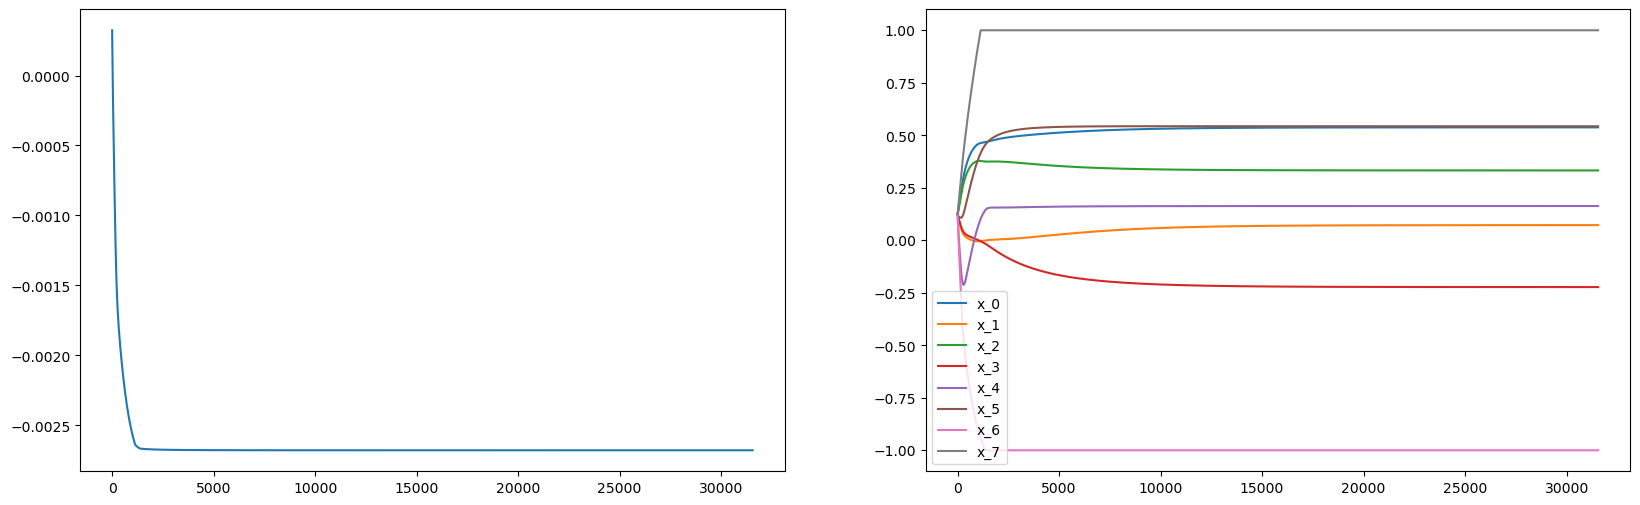

In [19]:
theta=1000; pi=4; initx = np.ones(8)/8
alpha = 0.5; beta=0.75; t_init=1; t_eps=1e-8; mu = 0.9; max_iter=50000

iter, converged, x_history, f_history, newx, newfval = run_momentum(theta, pi, ret_train, initx, alpha, beta, t_init, t_eps, mu, max_iter)
    
print(f"start at={initx}, converged {converged} at iter {iter}, final x={np.round(newx, 6)}, final f={np.round(newfval, 6)}")
if not converged: 
    finalgrad = eval_grad(theta, pi, ret_train,newx)
    print(f"final grad={finalgrad}, final grad l2 norm={np.linalg.norm(finalgrad)}")

plot_result(iter, x_history, f_history)

## full experiment, use 111 days of data

In [20]:
def get_delta(x, grad, momentum, olddelta, mu): 
    if not momentum:
        # if not momentum just negative gradient direction times step size
        delta = -grad
        for j in range(len(x)):
            if x[j] <= -1: delta[j] = max(0, delta[j]) # this is the critical correction, doing projection here
            if x[j] >= 1: delta[j] = min(0, delta[j])
        return delta
    
    else:
        # if momentum the convex combination of moving average and conventional step
        assert (olddelta is not None) and (mu is not None)
        delta = mu*(-grad) + (1-mu)*olddelta
        for j in range(len(x)):
            if x[j] <= -1: delta[j] = max(0, delta[j]) # this is the critical correction, doing projection here
            if x[j] >= 1: delta[j] = min(0, delta[j])
        return delta

def run_grad_desc(x, ret, pi, theta, x_history, f_history, bt, bt_a, bt_b, bt_init_step, momentum, mom_mu, max_iter, step_eps):
    converged = False
    iter = 0

    olddelta = np.zeros(len(x))

    while iter < max_iter:
        x_history[iter] = x
        fval = eval_func(theta, pi, ret, x)
        f_history[iter] = fval  
        grad = eval_grad(theta, pi, ret, x)
        delta = -grad
        if bt:
            # if backtrack, call backtrack function to compute step size
            step, goodstep = backtrack(theta, pi, ret, x, fval, grad, delta, bt_a, bt_b, bt_init_step, step_eps)
            # step, goodstep = backtrack(x, ret, pi, theta, fval, grad, -grad, bt_a, bt_b, step_eps, bt_init_step)
            # goodstep = True
        else:
            # if not backtrack, use constant step size
            step, goodstep = step_eps, True

        # one line to compute descent for both momentum and non-momentum case, with box constraints considered
        delta = get_delta(x, grad, momentum, olddelta, mom_mu)

        if goodstep:
            # if good step, descend
            # x = np.minimum(np.maximum(-1, x + step*delta), 1)
            newx = np.zeros(len(x))
            for j in range(len(x)):
                newx[j] = max(-1, x[j] + step * delta[j])
                newx[j] = min(1, newx[j]) # this is the critical correction, doing projection here
            newfval = eval_func(theta, pi, ret, newx)
            
            abs_one = np.isclose(np.abs(newx), 1)
            grad_zero = np.isclose(grad, 0)
            if np.logical_or(abs_one, grad_zero).all():
                converged = True
                print(f"Converged at {iter}")
                break
            
            x = newx
            
        iter += 1
    return iter, converged, x_history, f_history, newx, newfval

In [21]:
res = []

x = np.ones(8)/8
bt_a = 0.5; bt_b=0.75; bt_init_step=1; max_iter=100000

for theta,pi in [(5,2), (1000,4)]:
    for bt,mom in list(itertools.product([True, False], [True,False])):
        step_epss = [1e-8] if bt else [0.1, 1]
        mom_mus = [0.8, 0.9] if mom else [1]
        for step_eps,mom_mu in list(itertools.product(step_epss,mom_mus)):
            print("*"*60)
            print(f"RUNNING: theta={theta}, pi={pi}, bt={bt}, mom={mom}...")
            
            x_history = np.zeros((max_iter, len(x)))
            f_history = np.zeros(max_iter)

            iter, converged, x_history, f_history, newx, newfval = run_grad_desc(x, ret, pi, theta, x_history, f_history, 
                                                                                bt, bt_a, bt_b, bt_init_step, 
                                                                                mom, mom_mu, max_iter, step_eps)
            
            res.append({
                    "theta": theta,
                    "pi": pi,
                    "backtrack": bt,
                    "momentum": mom,
                    "momentum_mu": mom_mu, 
                    "step_size/step_eps": step_eps,
                    "converged": converged,
                    "converged_iter": iter,
                    "final_objective": newfval,
                    "final_portfolio": newx
                })
            
result_df = pd.DataFrame(res)

************************************************************
RUNNING: theta=5, pi=2, bt=True, mom=True...
Converged at 27845
************************************************************
RUNNING: theta=5, pi=2, bt=True, mom=True...
Converged at 24751
************************************************************
RUNNING: theta=5, pi=2, bt=True, mom=False...
Converged at 22275
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
Converged at 27845
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
Converged at 24751
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=False...
**************************************************

## result

In [22]:
result_df

,theta,pi,backtrack,momentum,momentum_mu,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio
0,5,2,True,True,0.8,1.000000e-08,True,27845,-0.001332,"[0.043422155043133216, 0.4867589427769092, 0.3..."
1,5,2,True,True,0.9,1.000000e-08,True,24751,-0.001332,"[0.04342215512445113, 0.4867589477552073, 0.34..."
2,5,2,True,False,1.0,1.000000e-08,True,22275,-0.001332,"[0.043422155066668446, 0.48675894473752046, 0...."
3,5,2,False,True,0.8,1.000000e-01,False,100000,-0.001332,"[0.04327213908871629, 0.47433450582115677, 0.3..."
4,5,2,False,True,0.9,1.000000e-01,False,100000,-0.001332,"[0.04331206435769003, 0.47876908693976294, 0.3..."
5,5,2,False,True,0.8,1.000000e+00,True,27845,-0.001332,"[0.043422155043133216, 0.4867589427769092, 0.3..."
6,5,2,False,True,0.9,1.000000e+00,True,24751,-0.001332,"[0.04342215512445113, 0.4867589477552073, 0.34..."
7,5,2,False,False,1.0,1.000000e-01,False,100000,-0.001332,"[0.043345599840679566, 0.4816271631644642, 0.3..."
8,5,2,False,False,1.0,1.000000e+00,True,22275,-0.001332,"[0.043422155066668446, 0.48675894473752046, 0...."
9,1000,4,True,True,0.8,1.000000e-08,True,58640,-0.002574,"[0.22586561831250698, 0.7223804996590864, 0.69..."


In [23]:
# fail to converge
result_df[result_df['converged']==False]

,theta,pi,backtrack,momentum,momentum_mu,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio
3,5,2,False,True,0.8,0.1,False,100000,-0.001332,"[0.04327213908871629, 0.47433450582115677, 0.3..."
4,5,2,False,True,0.9,0.1,False,100000,-0.001332,"[0.04331206435769003, 0.47876908693976294, 0.3..."
7,5,2,False,False,1.0,0.1,False,100000,-0.001332,"[0.043345599840679566, 0.4816271631644642, 0.3..."
12,1000,4,False,True,0.8,0.1,False,100000,-0.002573,"[0.20363161814652128, 0.6420657280267946, 0.70..."
13,1000,4,False,True,0.9,0.1,False,100000,-0.002574,"[0.20622949262528267, 0.657152201606356, 0.704..."
16,1000,4,False,False,1.0,0.1,False,100000,-0.002574,"[0.2088486293245363, 0.6691370009056732, 0.703..."


In [24]:
groupby_best_idx = result_df.loc[:,["theta", "pi", "final_objective"]].groupby(["theta", "pi"]).idxmin().values.flatten()
groupby_best = result_df.iloc[groupby_best_idx]
groupby_best

,theta,pi,backtrack,momentum,momentum_mu,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio
1,5,2,True,True,0.9,1.000000e-08,True,24751,-0.001332,"[0.04342215512445113, 0.4867589477552073, 0.34..."
10,1000,4,True,True,0.9,1.000000e-08,True,52124,-0.002574,"[0.2258656187969218, 0.7223805009498596, 0.693..."


# first-order barrier method

<span style='color:red'>**Extra credit**</span>
Suppose $x^*$ is the solution you compute above.  Next, solve the same optimization problem as above, except that you now have the constraint:
$$ \sum_j | x_j | \ \le \ 0.5*\sum_j |x^*_j |$$

Use a first-order barrier method, as covered in class, for this purpose.

Please be sure to have completed all other parts of this project before trying this part.  "Extra credit" = only valid if other parts have been done.

## eval_func_barrier, eval_grad_barrier

In [26]:
def eval_func_barrier(theta, pi, ret, x, xstar, lambdaval):
    # ret: (T,n)
    # x: (n,) 
    ret_bar = np.mean(ret, axis=0) # ret_bar: (n,)
    f1 = ret_bar.dot(x)
    
    ret_dev = ret - ret_bar # ret_dev: (T,n)
    ret_dev_x = ret_dev.dot(x) # ret_dev_x: (T,)
    f2 = np.mean( ret_dev_x**pi )

    f = -f1 + theta*f2
    barrier = -lambdaval*np.log(0.5*np.sum(np.abs(xstar))-np.sum(np.abs(x)))
    fb = f+barrier
    return fb

def eval_grad_barrier(theta, pi, ret, x, xstar, lambdaval):
    # ret: (T,n)
    # x: (n,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (n,)
    ret_dev = ret - ret_bar # ret_dev: (T,n)
    ret_dev_x = ret_dev.dot(x) # ret_dev_x: (T,)

    tmp = np.dot(ret_dev.T, ret_dev_x**(pi-1)) # tmp: (n,)
    T = ret.shape[0]
    g = -ret_bar + (theta*pi/T)*tmp # grad no barrier

    slack = 0.5*np.sum(np.abs(xstar))-np.sum(np.abs(x))
    sgn = np.where(x>0, -1, 1)
    gb = g-(lambdaval*sgn)/slack
    return gb

In [23]:
print(eval_grad(5,2,ret_train,np.ones(8)/8))

[ 2.09741933e-05  8.63619066e-04 -9.56235050e-05  8.81307680e-04
  4.10533428e-03  1.07157688e-03  3.93636316e-03 -7.30898132e-04]


In [27]:
lambdaval = 1e-8
xstar = np.array([0.3041,  0.0136,  0.0086, -0.1057,  0.0302,  0.3531, -0.589,   1.])
x = np.ones(8)/8

eval_func_barrier(5,2,ret_train, x, xstar, 10), eval_grad_barrier(5,2,ret_train, x, xstar, 1e-8)

(15.988198311392521,
 array([ 2.10236615e-05,  8.63668535e-04, -9.55740368e-05,  8.81357148e-04,
         4.10538375e-03,  1.07162635e-03,  3.93641262e-03, -7.30848664e-04]))

## backtrack_barrier

In [128]:
def backtrack_barrier(loud, theta, pi, ret, x, xstar, lambdaval, fval, grad, delta, alpha, beta, t_init, t_eps, epsilon, zerotol): 
    # alpha = 0.5, beta = 0.75, t_init = 1, t_eps = 1e-8
    gradtimesdelta = grad.dot(delta)
    t = t_init

    '''
    # barrier constraint
    for i in range(D):
        newxi = x[i] + step * delta[i]
        if newxi + epsilon >= 1:
            step = (1 - x[i] - epsilon) / delta[i]
        elif newxi - epsilon <= -1:
            step = (-1 + epsilon - x[i]) / delta[i]
    
    # print("\tAfter box contraint:", step)
    # total constraint
    for i in range(D):
        newx = np.copy(x)
        newx[i] = x[i] + step * delta[i]
        if np.abs(newx).sum() + epsilon > 0.5 * np.abs(x_star).sum():
            newxsum = 0.5 * np.abs(x_star).sum() - epsilon
            absnewxi = newxsum - np.abs(np.delete(newx, i)).sum()
            newx_target = absnewxi if newx[i] > 0 else -absnewxi
            step = (newx_target - x[i]) / delta[i]
    '''

    # box constraint
    for i in range(len(x)):
        newxi = x[i] + t * delta[i]
        if newxi + epsilon >= 1 and abs(delta[i]) > zerotol:
            t = (1 - x[i] - epsilon) / delta[i]
            if loud: print(f"\t After box constraint {i} x<=1, t=", t)
        if newxi - epsilon <= -1 and abs(delta[i]) > zerotol:
            t = (-1 + epsilon - x[i]) / delta[i]
            if loud: print(f"\t After box constraint {i}  x>=-1, t=", t)

    # total constraint
    for i in range(len(x)):
        newx = np.copy(x)
        newx[i] = x[i] + t * delta[i]
        if np.sum(np.abs(newx)) + epsilon > 0.5 * np.sum(np.abs(xstar)) and abs(delta[i]) > zerotol:
            newxsum = 0.5 * np.abs(xstar).sum() - epsilon # sum of abs of all x
            absnewxi = newxsum - np.abs(np.delete(newx, i)).sum() # sum of abs of all x - sum of abs excluding i-th x
            newx_target = absnewxi if newx[i]>0 else -absnewxi
            if loud: print(f"\t violate total constraint {i}: absnewxi={newxi}, newx_target={newx_target}, delta {i}={delta[i]}")
            t = (newx_target - x[i]) / delta[i]
            if loud: print(f"\t After total constraint {i}, t={t}") 

    goon = True
    success = False
    
    if t < t_eps: 
        goon = False
        t = 0

    while goon:
        xnew = x+t*delta
        fnew = eval_func_barrier(theta, pi, ret, xnew, xstar, lambdaval)
        target = alpha*t*gradtimesdelta 
        if fnew - fval <= target: # target means the difference that is acceptable between fnew and fval
            goon = False
            success = True # accept if small enough
        else:
            t *= beta
        if t < t_eps: 
            if fnew <= fval: success = True
            goon = False

    return t, success

In [129]:
def run_backtrack_barrier(theta, pi, ret, x, xstar, lambdaval, alpha, beta, t_init, t_eps, epsilon, zerotol, max_iter):
    converged = False
    x_history = np.zeros((max_iter, len(x)))
    f_history = np.zeros(max_iter)
    
    iter = 0
    while iter < max_iter:
        
        loud = iter>=235

        x_history[iter] = x
        fval = eval_func_barrier(theta, pi, ret, x, xstar, lambdaval)
        f_history[iter] = fval
        
        grad = eval_grad_barrier(theta, pi, ret, x, xstar, lambdaval)

        delta = -grad
        
        for j in range(len(x)):
            if x[j]-epsilon <= -1: delta[j] = max(0.0, delta[j]) # this is the critical correction, doing projection here
            if x[j]+epsilon >= 1: delta[j] = min(0.0, delta[j])
        
        t, goodstep = backtrack_barrier(loud, theta, pi, ret, x, xstar, lambdaval, fval, grad, delta, alpha, beta, t_init, t_eps, epsilon, zerotol)
        
        if t==0:
            print(f"iter={iter}, t={t}, goodstep={goodstep}, x={x}, fval={fval}, grad={grad}")
            break
        
        if loud: print(f"iter={iter}, t={t}, goodstep={goodstep}, x={x}, fval={fval}, grad={grad}")
        
        if goodstep:
            newx = x+t*delta
            newfval = eval_func_barrier(theta, pi, ret, newx, xstar, lambdaval)

            grad_zero = np.isclose(grad, 0)
            abs_one = np.isclose(np.abs(newx), 1)
            if np.logical_or(grad_zero, abs_one).all():
                converged = True
                print(f"Converged at {iter}")
                break

            x = newx
        '''
        else:
            print('Breaking off because of inadequate fval improvement')
            break
        '''
        iter +=1
    return iter, converged, x_history, f_history, newx, newfval

In [130]:
theta = 5; pi = 2
x = np.ones(8)/8
#xstar = np.array([0.3041,  0.0136,  0.0086, -0.1057,  0.0302,  0.3531, -0.589,   1.])
xstar = np.array([0.30413, 0.01365, 0.00862, -0.10567, 0.03021, 0.35313, -0.58899, 1.0])
lambdaval = 1e-10
alpha = 0.5; beta=0.75; t_init=1; t_eps=1e-20
epsilon = 1e-2; zerotol = 1e-10
max_iter=500

In [131]:
iter, converged, x_history, f_history, newx, newfval = run_backtrack_barrier(theta, pi, ret_train, x, xstar, lambdaval, 
                                                                             alpha, beta, t_init, t_eps, epsilon, zerotol, max_iter)

iter=235, t=1, goodstep=True, x=[ 0.18853839  0.04541308  0.17484699  0.03942484 -0.07636802  0.09554792
 -0.26595084  0.30207367], fval=-0.0008098770913446199, grad=[-0.00029239  0.00012223 -0.00018009  0.0001522  -0.00016299 -0.00020549
  0.00076241 -0.00071744]
iter=236, t=1, goodstep=True, x=[ 0.18883078  0.04529084  0.17502708  0.03927264 -0.07620503  0.0957534
 -0.26671325  0.30279112], fval=-0.0008111966127498931, grad=[-0.00029176  0.00012155 -0.00017942  0.00015154 -0.0001641  -0.00020608
  0.0007597  -0.00071698]
	 violate total constraint 6: absnewxi=0.30422462239427195, newx_target=-0.2680720571046935, delta 6=-0.0007570082922670761
	 After total constraint 6, t=0.7914159117038548
iter=237, t=0.7914159117038548, goodstep=True, x=[ 0.18912253  0.04516929  0.1752065   0.0391211  -0.07604093  0.09595949
 -0.26747295  0.3035081 ], fval=-0.0008125109888564551, grad=[-0.00029113  0.00012087 -0.00017875  0.00015089 -0.00016518 -0.00020667
  0.00075701 -0.00071652]
	 violate total 

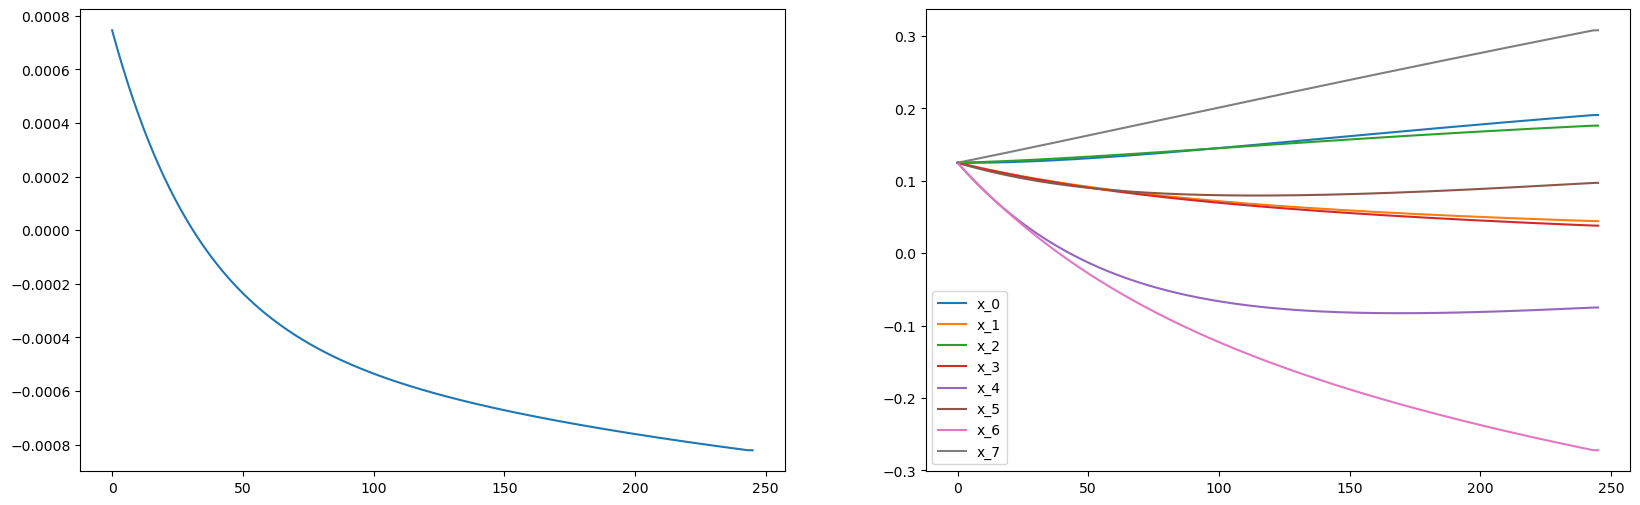

In [107]:
plot_result(iter, x_history, f_history)